# Assignment 4 - part 1
Training a simple neural net for relation classification.
In this assignment you are required :
* to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

  1. The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). 
  2. The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.
  3. The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)
  4. In this work we will use the hugingface framework for transformers training and inference.
  5. We recomand reading the d4.ocumentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


In [ ]:
!pip install transformers
!pip install torchinfo
!pip install torch-info
!pip install torchsummary
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch-info (from versions: none)
ERROR: No matching distribution found for torch-info
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-

In [ ]:
import torch
import torch.nn as nn
from google.colab import drive
import os
import numpy as np
import math
from tabulate import tabulate

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoConfig, AutoModel
from transformers import AdamW

from torchsummary import summary
from numpy.random import default_rng
import gc
import pandas as pd 
from tqdm.notebook import tqdm_notebook
from IPython.display import display
import warnings
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold

warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

display on which device the model will be trained

In [ ]:
print(device)

cuda


# part 1 - Bert finetunning 

In [ ]:
!git clone https://github.com/kfirbar/nlp-course

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [ ]:
main_folder = 'nlp-course'
train_path = os.path.join(main_folder, 'TRAIN_FILE.TXT')
test_path = os.path.join(main_folder, 'TEST_FILE_FULL.TXT')
BERT_CHECKPOINT = 'BERT_CHECKPOINT'

Mounted at /content/gdrive


## Task 1 - read data : 
Write a funtion *read_data* for reading the data from a single file (either train or test). 
1. This function recieves a filepath and returns a list of sentence.
2. Every sentence is encoded as a touple
    * first element is the sentence string
    * second the label (also represented as a sting). 

In [ ]:

def read_data(filepath, remove_entity = True):
    """
    Parameters
    ----------
    filepath : string
    DESCRIPTION:
        1. for given path we read the txt file into list 
        2. for each sentence is shift of 4 index 0,4,8,....,4n, the label
           is the same only from the index 1,5,9,...4n+1
        3. first we will slice the sentences, and labels 
        4. for each setnence we will remodve the TAB & "\n" 
            ([1:-1] to remove the double quating ) 
        
          for each labels needed to remove  space and "\n"
        5. finnaly we need to concat setence to label to list of tupples 
    Returns
    -------
    data : list 
        list of tupples [ (sentence, label), (), ....].
    """
    # 1
    with open(filepath) as file:
        output = file.readlines()
  
    # 2
    STEP = 4
    
    # 3
    labels  = output[1::STEP]
    sentences  = output[0::STEP]

    #4 
    # sentence splited
    if remove_entity:
      sentences = list(map(lambda x: x.split('\t')[1].replace('\n', '').replace('</e2>', '').replace('</e1>', '').replace('<e1>', '').replace('<e2>', '')[1:-1], sentences))

    else:
      sentences = list(map(lambda x: x.split('\t')[1].replace('\n', '')[1:-1], sentences))
    labels = list(map(lambda x: x.replace('\n', '').replace('(e2,e1)', '').replace('(e1,e2)', ''), labels))

    # 5
    data = list(zip(sentences, labels))
    
    return data



In [ ]:
train = read_data(train_path)
test = read_data(test_path)

Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [ ]:
def from_list_of_list_2_single_list(list_of_list):
    # convertign list of list to single list with all ellements
    flat_list = [item for sublist in list_of_list for item in sublist]
    return flat_list

def get_unique_tokens_and_token_indexs(data, is_sentence = True):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    is_sentence : Bollan
        indicate whether to get setnece or label
    
    
    1. get desire list sentences\labels 
    2. split into tokens
    3. convert to single list with all ellements
    4. doing unique the list to get unique value and index 
    5. generate dict\mapper from token 2 index
    
    Returns
    -------
    mapper_dict : dict
        map from unique token to unique index

    """
    #1
    if is_sentence:
        list_of_list = list(map(lambda x: x[0], data))

    # label
    else: 
        list_of_list = list(map(lambda x: x[1], data))
    
    #2
    list_of_list_tokens = list(map(lambda x: x.split(' '), list_of_list))

    #3
    all_tokens = from_list_of_list_2_single_list(list_of_list_tokens)

    #4
    unique_tokens =list(set(all_tokens))

    #5
    mapper_dict = dict(zip(unique_tokens,np.arange(0, unique_tokens.__len__())))
    return mapper_dict

def create_label_mapper(data):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    Returns
    -------
    sentences_mapper : dict
        map from unique token to unique index
    labels_mapper : dict
        map from unique token to unique index
    """ 
    labels_mapper = get_unique_tokens_and_token_indexs(data, is_sentence = False)
    return labels_mapper

In [ ]:
label_mapper = create_label_mapper(train)
labels = list(label_mapper.keys())
num_labels = labels.__len__()
pd.DataFrame(label_mapper.values(), index =label_mapper.keys(), columns = ['label idx'])

label idx
Member-Collection           0
Message-Topic               1
Other                       2
Cause-Effect                3
Product-Producer            4
Instrument-Agency           5
Entity-Origin               6
Component-Whole             7
Content-Container           8
Entity-Destination          9

## Task 2  - prepare data : 
Write a function *prepare_data* that 
1. takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. 
2. The function also aggregate the samples into batches. 
3. BERT Uses pretrained tokanization and embedding. 
4. you can access the tokanization and indexing using the BertTokenizer class.


In [ ]:
batch_size = 8
MAX_LENGTH = 256

In [ ]:
def get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels = 10, remove_entity = False):
    """
    getting tuple size 3 base data item  (tensor input, mask tensor, label iteger)
    """
    # get setnece and label
    i_sentence = i_data[sentence_tuple_idx]
    i_label = i_data[label_tuple_idx]

    # do tokenization to the setnence
    i_tensor_input = tokenizer(i_sentence, max_length=MAX_LENGTH,  padding='max_length',return_tensors="pt")

    i_tensor_input = list(i_tensor_input.values())
    # get label
    i_label = labels_mapper[i_label]
    i_label = torch.tensor([i_label])
    return i_tensor_input, i_label

def prepare_data(data, tokenizer, batch_size=8, num_labels = 10, remove_entity = False):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    tokenizer : generator of transformers pakage
        for given sentence return dict of:
            1. input idx - tensor
            2. mask  - tensor 
            3. attention_mask - tensor
            
    batch_size : int, optional
        DESCRIPTION. The default is 8, the size of batch, after 8 input model will do backprop'.

    Returns
    -------
    data_sequences : list of tuples 
        the input to our model

    """
    data_sequences = []
    sentence_tuple_idx = 0
    label_tuple_idx = 1

    labels_mapper = create_label_mapper(data)
    for sentence_idx, i_data in enumerate(data):
      
        # 
        i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels, remove_entity)

        # initiate batch input list
        if sentence_idx ==0 or ids_tensor.shape[0]%batch_size == 0 :
            # print(sentence_idx)
            # print(batch_size)

            ids_tensor = i_tensor_input[0]
            idx_tensor = i_tensor_input[1]
            attention_mask_tensor = i_tensor_input[2]
            label_tensor = i_label
        else:
            # append batch data
            # print(sentence_idx)
            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)

        # if batch list is fill append batch data to all data 
        if ids_tensor.shape[0]%(batch_size) == 0:
            batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor]
            data_sequences.append(batch_data)
    
    padd_last_batch_size =  batch_size - ids_tensor.shape[0] 
    if padd_last_batch_size>0:
        rng = default_rng()
        choosen_idx = \
            rng.choice(range(0, data.__len__()-padd_last_batch_size), size=padd_last_batch_size, replace=False)
        for i_idx in choosen_idx:
            
            i_data = data[i_idx]
            
            # get single input
            i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer)
            
            # append batch data
            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)

        # append batch data
        batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor]
        data_sequences.append(batch_data)       

    return data_sequences



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_sequences = prepare_data(train, tokenizer, batch_size = batch_size)
test_sequences = prepare_data(test, tokenizer, batch_size = batch_size)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Task 3 - get model parameters : 
In this part we classify the sentences using the BertForSequenceClassification model.
1. To save resources, we initialize the optimizer with the final layer of the model. 
2. You are also allowed to change the learning rate.

In [ ]:
def get_parameters(params, debug = False):
    """
    Parameters
    ----------
    params : pythorch model.named_parameters()

    Returns
    -------
    layers : TYPE
        DESCRIPTION.
    """
    # initiate layers 
    layers = []
    # run on all model layers 
    for name, param in params:
        # set when on which layer needed to do backprop'
        if ('classifier' in name) | ('bert.pooler' in name) and debug :
         print(name)
        param.requires_grad = ('classifier' in name) | ('bert.pooler' in name)
        # append layer
        layers.append(param)
    return layers

## set hyperparameters for bert finetunning 

In [ ]:
# constants
epochs = 250
lr = 1e-3

## load  model


In [ ]:


# define the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# set a bert model 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## print model summary

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## set optimizer

In [ ]:
# define the optimizer Adam  - is a fancy version of SGD)
optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=lr)

## Task 4 - set train loop  : 
Write a training loop
1. takes a BertForSequenceClassification model 
2. train for number of epochs to train on.
3. The loss is always CrossEntropyLoss 
4. optimizer is always Adam. 
5. You are allowed to split the train to train and dev sets.

In [ ]:

def get_model_results(model, test_sequences):
    """
    Parameters
    ----------
    model : Torch model  - 
        DESCRIPTION: LSTM model.
    test_sequences : list
        DESCRIPTION: input list of coupels [[word_tensor, lebel_tensor] , ...]
    
    the function get model results
    
    Returns
    -------
    all_test_words_pred : list
    all_test_words_true : list
    """
    # generate test tokens prediction
    all_test_words_pred = []
    all_test_words_true = []
    for sentence, labels in test_sequences:
        ids_tensor = sentence[0]
        idx_tensor = sentence[1]
        attention_mask_tensor = sentence[2]

        labels_tensor = labels.to(device)
        logits = model( input_ids = ids_tensor.to(device), attention_mask = attention_mask_tensor.to(device))

        logits = logits.logits
        
        _, pred_labels =logits.T.max(0)

        all_test_words_pred += pred_labels.tolist()
        all_test_words_true += labels.tolist()
    curr_f1_accuracy_result = f1_score(all_test_words_true, all_test_words_pred,  average='macro')
    return all_test_words_pred, all_test_words_true, curr_f1_accuracy_result
def train_loop(model, n_epochs, train_data, label_mapper, dev_data = None, alpha_zero = 2e-5 ):
  """

    Parameters
    ----------
    model : torch model
        Bert model from transofrmers library.
    n_epochs : int
        amount of aphoces
    train_data : list
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label
    label_mapper : dict
        mapper from label name to labels index 
    dev_data : TYPE, optional
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label
    alpha_zero : float
        DESCRIPTION. intial learning rate - The default is 1e-3.

    discrition of functio:
        train the model for n_epochs, for each 5 aphocs the training caluclate
        his f-score results
    
    Returns
    -------
    model : torch model
       torch model after traning for n ephocs

  """ 
  if dev_data is None:
    dev_data = train_data
  update_lr_after_n_aphoc = 1  
  # Loss function
  criterion = nn.CrossEntropyLoss()
  all_target_names = list(label_mapper.keys())

  optimizer = AdamW(get_parameters(model.named_parameters()), lr=alpha_zero)
  
  curr_f1_accuracy_result = 0
  best_f1_accuracy_result = 0
  best_df = pd.DataFrame()
  old_lr  = alpha_zero
 
  best_model = model

  for ephoc_index in range(1, n_epochs + 1):

    desc = ('Ephoc #' + str(ephoc_index))
    for sequence_idx in tqdm_notebook(range(train_data.__len__()), desc = desc):
        
        
        # get sentence tokens, and labels 
        batch_data =  train_data[sequence_idx]

        # get batch label and data 
        i_batch_data =  batch_data[0]
        i_batch_data_labels = batch_data[1]       

        # check if there is empty sentence
        if i_batch_data.__len__() == 0:
            continue
    
        # Sets the gradients of all optimized to zero.
        model.zero_grad()
        
        # foward sentence to model
        ids_tensor = i_batch_data[0]
        idx_tensor = i_batch_data[1]
        attention_mask_tensor = i_batch_data[2]

        # foward inputs in the model 
        logits = model( input_ids = ids_tensor.to(device),  attention_mask = attention_mask_tensor.to(device))
        logits = logits.logits

        # Computes the gradient of current tensor
        criterion(logits, i_batch_data_labels.to(device)).backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # once the gradients are computed use them to optimize model
        optimizer.step()
    
    # update lr rate
    cos_inner = np.pi * (ephoc_index % (n_epochs // update_lr_after_n_aphoc))  
    cos_inner /= n_epochs // update_lr_after_n_aphoc
    cos_out = np.cos(cos_inner) + 1
    new_lr = float(alpha_zero / 2 * cos_out) # needed to be seen
    lr_string = '\nlearning rate we decay from value = ' + str(new_lr) + ' to the value = '+ str(old_lr)
    old_lr  = new_lr

    # update optimizer lr update apdating the lr
    optimizer = AdamW(get_parameters(model.named_parameters()), lr=new_lr)

    # free memory from the GPU
    torch.cuda.empty_cache()
    gc.collect()
    
    if ephoc_index< int(0.667*n_epochs):
      check_score_any_n_aphoc = 10
    else:
      check_score_any_n_aphoc = 5

    # for any 5 ephoces show results, whether model is improved  
    if ephoc_index%check_score_any_n_aphoc== 0 and  ephoc_index != 0:
      
      print('finshed ephoc #' + str(ephoc_index) + ', ephoch results:' , flush = True)
      # get f1 score for i ephoc
      all_train_words_pred, all_train_words_true, curr_f1_accuracy_result = get_model_results(model, dev_data)

      # state if accuracy results was improved
      if curr_f1_accuracy_result > best_f1_accuracy_result:
        improve_string = 'f1-accuracy-score improve from ' + str(best_f1_accuracy_result) + ' to ' + str(curr_f1_accuracy_result) 
        best_f1_accuracy_result = curr_f1_accuracy_result
        best_model = model
      else:
        improve_string = 'f1-accuracy-score did not improve from ' + str(best_f1_accuracy_result)  
      improve_string += lr_string
      print(improve_string, flush = True)
      
    # release memory 
    torch.cuda.empty_cache()
    gc.collect()
    
  return best_model 

## Task 5 - train and evaluation:
write an evaluation loop on a trained model, using the dev and test datasets. 
1. This function print the true positive rate (TPR), also known as Recall 
2. the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total)
3.  and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

## set evaluation  

In [ ]:
def evaluate(model, test_data, MTB = False):
    """
    

    Parameters
    ----------
    model : torch model
        model after training 
    test_data : list
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label

    Returns
    -------
    pred_labels : list 
        list of predictions
    true_labels : TYPE
        list of true labels

    """

    # Put model in evaluation mode
    model.eval()

    # evaluation
    if not MTB:
      pred_labels, true_labels, curr_f1_accuracy_result = get_model_results(model, test_data)
    else:
      pred_labels, true_labels, curr_f1_accuracy_result = get_model_results_MTB(model, test_data)


    # return model in evaluation mode
    model.train()
    return pred_labels, true_labels, curr_f1_accuracy_result

## set precision & recall function:
in term of precision & recall   

In [ ]:
def calc_precision_recall(pred_labels, true_labels, label_mapper):
    """
    Parameters
    ----------
    pred_labels : list
        list of predictions
    true_labels : list
        list of true labels.
    label_mapper : dict
        mapper from label name to labels index

    print model results
    
    Returns
    -------
        None.
    """

    # get labels names 
    results_dict = dict.fromkeys(label_mapper.keys())

    # 
    idx_to_labels_dict = {value:key for key, value in label_mapper.items()}

    rows =[]
    total_precision = 0
    total_recall = 0


    for key in results_dict.keys():
        results_dict[key] = {"TP": 0, "FP": 0, "FN": 0}
    # run on all predictions
    for i in range(len(pred_labels)):
        # get results and predictions 
        pred_label = pred_labels[i]
        true_label = true_labels[i]

        # check if predict the right prediction == target
        if pred_label == true_label:
            TP_label = idx_to_labels_dict[pred_label]
            results_dict[TP_label]["TP"] +=1
        # otherwise
        else:
            FP_label = idx_to_labels_dict[pred_label]
            FN_label = idx_to_labels_dict[true_label]

            results_dict[FP_label]["FP"] +=1
            results_dict[FN_label]["FN"] +=1
    # for each label get results to calculate the precision and recall
    for label in results_dict.keys():
        TP = results_dict[label]["TP"]
        FP = results_dict[label]["FP"]
        FN = results_dict[label]["FN"]

        precision = TP/(TP+FP)
        recall = TP/(TP+FN)

        rows.append([label, precision, recall])

        total_precision += precision
        total_recall += recall
    
    # do average for all predictions and append those results
    total_precision /= len(results_dict)
    total_recall /= len(results_dict)
    rows.append(["All Together", total_precision, total_recall])
    results_df = pd.DataFrame(rows, columns = ['label', 'precision', 'recall'])
    
    # display the summary of results
    display(results_df)
    return

In [ ]:
train_sequences, dev_sequences = train_test_split(train_sequences,test_size=0.1,random_state=10)

## train mode
 * because training is slow, we save check point and trained it from check point for 400 ephocs

In [ ]:
torch.cuda.empty_cache()
gc.collect()
model.train()
  
model = train_loop(model, n_epochs=epochs, train_data=train_sequences, label_mapper = label_mapper, alpha_zero = lr)


Ephoc #1:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #2:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #3:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #4:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #5:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #6:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #7:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #8:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #9:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #10:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #10, ephoch results:
f1-accuracy-score improve from 0 to 0.6273698697457584
learning rate we decay from value = 0.000996057350657239 to the value = 0.0009968056552600042


Ephoc #11:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #12:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #13:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #14:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #15:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #16:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #17:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #18:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #19:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #20:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #20, ephoch results:
f1-accuracy-score improve from 0.6273698697457584 to 0.6436383761728184
learning rate we decay from value = 0.0009842915805643156 to the value = 0.000985815866457337


Ephoc #21:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #22:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #23:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #24:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #25:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #26:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #27:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #28:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #29:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #30:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #30, ephoch results:
f1-accuracy-score did not improve from 0.6436383761728184
learning rate we decay from value = 0.0009648882429441257 to the value = 0.0009671644712283061


Ephoc #31:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #32:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #33:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #34:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #35:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #36:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #37:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #38:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #39:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #40:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #40, ephoch results:
f1-accuracy-score did not improve from 0.6436383761728184
learning rate we decay from value = 0.0009381533400219318 to the value = 0.0009411456132174767


Ephoc #41:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #42:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #43:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #44:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #45:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #46:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #47:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #48:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #49:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #50:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #50, ephoch results:
f1-accuracy-score did not improve from 0.6436383761728184
learning rate we decay from value = 0.0009045084971874737 to the value = 0.0009081696253585921


Ephoc #51:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #52:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #53:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #54:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #55:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #56:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #57:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #58:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #59:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #60:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #60, ephoch results:
f1-accuracy-score did not improve from 0.6436383761728184
learning rate we decay from value = 0.0008644843137107057 to the value = 0.000868756558679087


Ephoc #61:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #62:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #63:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #64:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #65:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #66:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #67:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #68:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #69:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #70:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #70, ephoch results:
f1-accuracy-score did not improve from 0.6436383761728184
learning rate we decay from value = 0.0008187119948743449 to the value = 0.0008235279807847222


Ephoc #71:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #72:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #73:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #74:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #75:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #76:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #77:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #78:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #79:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #80:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #80, ephoch results:
f1-accuracy-score improve from 0.6436383761728184 to 0.656565428715284
learning rate we decay from value = 0.0007679133974894983 to the value = 0.0007731971733671345


Ephoc #81:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #82:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #83:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #84:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #85:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #86:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #87:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #88:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #89:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #90:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #90, ephoch results:
f1-accuracy-score improve from 0.656565428715284 to 0.6703518740824742
learning rate we decay from value = 0.0007128896457825364 to the value = 0.0007185578833254665


Ephoc #91:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #92:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #93:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #94:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #95:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #96:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #97:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #98:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #99:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #100:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #100, ephoch results:
f1-accuracy-score did not improve from 0.6703518740824742
learning rate we decay from value = 0.0006545084971874737 to the value = 0.0006604718049036047


Ephoc #101:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #102:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #103:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #104:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #105:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #106:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #107:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #108:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #109:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #110:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #110, ephoch results:
f1-accuracy-score did not improve from 0.6703518740824742
learning rate we decay from value = 0.0005936906572928623 to the value = 0.0005998549902572035


Ephoc #111:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #112:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #113:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #114:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #115:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #116:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #117:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #118:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #119:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #120:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #120, ephoch results:
f1-accuracy-score did not improve from 0.6703518740824742
learning rate we decay from value = 0.0005313952597646568 to the value = 0.0005376634027639665


Ephoc #121:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #122:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #123:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #124:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #125:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #126:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #127:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #128:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #129:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #130:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #130, ephoch results:
f1-accuracy-score improve from 0.6703518740824742 to 0.671538237126053
learning rate we decay from value = 0.0004686047402353434 to the value = 0.00047487784091011526


Ephoc #131:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #132:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #133:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #134:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #135:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #136:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #137:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #138:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #139:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #140:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #140, ephoch results:
f1-accuracy-score did not improve from 0.671538237126053
learning rate we decay from value = 0.0004063093427071377 to the value = 0.00041248847051236206


Ephoc #141:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #142:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #143:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #144:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #145:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #146:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #147:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #148:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #149:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #150:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #150, ephoch results:
f1-accuracy-score did not improve from 0.671538237126053
learning rate we decay from value = 0.00034549150281252633 to the value = 0.00035147920921148253


Ephoc #151:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #152:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #153:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #154:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #155:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #156:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #157:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #158:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #159:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #160:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #160, ephoch results:
f1-accuracy-score improve from 0.671538237126053 to 0.6762631244033062
learning rate we decay from value = 0.00028711035421746366 to the value = 0.00029281220950335795


Ephoc #161:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #162:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #163:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #164:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #165:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #166:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #167:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #168:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #169:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #170:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #170, ephoch results:
f1-accuracy-score improve from 0.6762631244033062 to 0.6876994789204235
learning rate we decay from value = 0.00023208660251050178 to the value = 0.00023741268501935208


Ephoc #171:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #172:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #173:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #174:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #175:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #175, ephoch results:
f1-accuracy-score did not improve from 0.6876994789204235
learning rate we decay from value = 0.00020610737385376348 to the value = 0.0002112136482888663


Ephoc #176:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #177:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #178:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #179:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #180:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #180, ephoch results:
f1-accuracy-score did not improve from 0.6876994789204235
learning rate we decay from value = 0.00018128800512565513 to the value = 0.00018615431935464983


Ephoc #181:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #182:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #183:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #184:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #185:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #185, ephoch results:
f1-accuracy-score improve from 0.6876994789204235 to 0.6882206451254917
learning rate we decay from value = 0.0001577264470356558 to the value = 0.00016233359593948777


Ephoc #186:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #187:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #188:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #189:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #190:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #190, ephoch results:
f1-accuracy-score improve from 0.6882206451254917 to 0.6891935561261386
learning rate we decay from value = 0.00013551568628929417 to the value = 0.00013984548755604655


Ephoc #191:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #192:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #193:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #194:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #195:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #195, ephoch results:
f1-accuracy-score improve from 0.6891935561261386 to 0.6897538623237637
learning rate we decay from value = 0.00011474337861210544 to the value = 0.00011877874449427617


Ephoc #196:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #197:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #198:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #199:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #200:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #200, ephoch results:
f1-accuracy-score did not improve from 0.6897538623237637
learning rate we decay from value = 9.549150281252633e-05 to the value = 9.921650756456164e-05


Ephoc #201:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #202:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #203:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #204:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #205:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #205, ephoch results:
f1-accuracy-score improve from 0.6897538623237637 to 0.6983884540672186
learning rate we decay from value = 7.783603724899247e-05 to the value = 8.123597997892917e-05


Ephoc #206:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #207:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #208:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #209:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #210:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #210, ephoch results:
f1-accuracy-score did not improve from 0.6983884540672186
learning rate we decay from value = 6.184665997806821e-05 to the value = 6.490812266523716e-05


Ephoc #211:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #212:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #213:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #214:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #215:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #215, ephoch results:
f1-accuracy-score did not improve from 0.6983884540672186
learning rate we decay from value = 4.758647376699032e-05 to the value = 5.029737421681446e-05


Ephoc #216:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #217:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #218:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #219:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #220:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #220, ephoch results:
f1-accuracy-score improve from 0.6983884540672186 to 0.7001450058173524
learning rate we decay from value = 3.511175705587427e-05 to the value = 3.746139658277092e-05


Ephoc #221:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #222:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #223:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #224:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #225:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #225, ephoch results:
f1-accuracy-score improve from 0.7001450058173524 to 0.7022853715009729
learning rate we decay from value = 2.4471741852423235e-05 to the value = 2.6450847502627883e-05


Ephoc #226:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #227:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #228:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #229:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #230:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #230, ephoch results:
f1-accuracy-score did not improve from 0.7022853715009729
learning rate we decay from value = 1.5708419435684463e-05 to the value = 1.730918058336306e-05


Ephoc #231:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #232:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #233:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #234:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #235:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #235, ephoch results:
f1-accuracy-score did not improve from 0.7022853715009729
learning rate we decay from value = 8.856374635655639e-06 to the value = 1.0072473807876569e-05


Ephoc #236:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #237:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #238:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #239:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #240:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #240, ephoch results:
f1-accuracy-score did not improve from 0.7022853715009729
learning rate we decay from value = 3.942649342761117e-06 to the value = 4.769287151674407e-06


Ephoc #241:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #242:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #243:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #244:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #245:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #245, ephoch results:
f1-accuracy-score did not improve from 0.7022853715009729
learning rate we decay from value = 9.866357858642206e-07 to the value = 1.420549869693033e-06


Ephoc #246:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #247:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #248:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #249:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #250:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #250, ephoch results:
f1-accuracy-score did not improve from 0.7022853715009729
learning rate we decay from value = 0.001 to the value = 3.947789809194413e-08


 ## evaluate trained model

In [ ]:
pred_labels, true_labels, f_score  = evaluate(model, test_sequences)

## test F-score

In [ ]:
print('on test set we acheive the following score ' + str(f_score))

on test set we acheive the following score 0.5571750592978029


## display precision & recall results 

In [ ]:
calc_precision_recall(pred_labels, true_labels, label_mapper)     

label  precision    recall
0      Component-Whole   0.537994  0.567308
1         Cause-Effect   0.687151  0.750000
2   Entity-Destination   0.657321  0.722603
3        Message-Topic   0.642612  0.713740
4                Other   0.316629  0.304825
5    Member-Collection   0.593301  0.532189
6        Entity-Origin   0.515556  0.449612
7     Product-Producer   0.474138  0.476190
8    Instrument-Agency   0.437956  0.384615
9    Content-Container   0.726257  0.677083
10        All Together   0.558891  0.557817

# part 2 - MTV- Finetunnign 

## Task 6  - entity markers:
improve the model accuracy by using a method called "entity markers
Entity:
*  The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. 
* instead of using the CLS toekn for clasification
* we will use the concatination of the embedding of [e1] and [e2] as shown in the image below.
* The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2).
* To use this method we'll need to create a new data load and a new model.

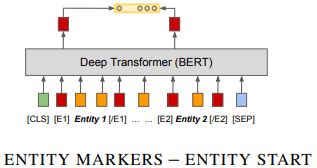

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_MTB = tokenizer
tokenizer_MTB.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

## read MTB data

In [ ]:
train = read_data(train_path, remove_entity = False)
test = read_data(test_path, remove_entity = False)

## set MTB hyperparameters 

In [ ]:
n_epoch_MTB = 300
lr_MTB = 1e-3
batch_size_MTB = 8

## generate MTB label mapper

In [ ]:
labels_dict_MTB = create_label_mapper(train)
labels = list(labels_dict_MTB.keys())
num_labels = labels.__len__()
pd.DataFrame(labels_dict_MTB.values(), index =labels_dict_MTB.keys(), columns = ['label idx'])

label idx
Component-Whole             0
Cause-Effect                1
Entity-Destination          2
Message-Topic               3
Other                       4
Member-Collection           5
Entity-Origin               6
Product-Producer            7
Instrument-Agency           8
Content-Container           9

## Set MTB prepare data  

In [ ]:
def MTB_get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels = 10):
    """
    getting tuple size 3 base data item  (tensor input, mask tensor, label iteger)
    """

    # get setnece and label
    i_sentence = i_data[sentence_tuple_idx]
    i_label = i_data[label_tuple_idx]

    # do tokenization to the setnence
    i_tensor_input = tokenizer(i_sentence, max_length=MAX_LENGTH,  padding='max_length',return_tensors="pt", add_special_tokens=True)
    i_tensor_input = list(i_tensor_input.values())
    
    # get label
    i_label = labels_mapper[i_label]
    i_label = torch.tensor([i_label])

    return i_tensor_input, i_label

def prepare_data_MTB(data, tokenizer, batch_size=8, num_labels = 10, remove_entity = False):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    tokenizer : generator of transformers pakage
        for given sentence return dict of:
            1. input idx - tensor
            2. mask  - tensor 
            3. attention_mask - tensor
            
    batch_size : int, optional
        DESCRIPTION. The default is 8, the size of batch, after 8 input model will do backprop'.

    Returns
    -------
    data_sequences : list of tuples 
        the input to our model

    """

    e1_start=tokenizer.added_tokens_encoder['<e1>']
    e2_start=tokenizer.added_tokens_encoder['<e2>']

    data_sequences = []
    
    sentence_tuple_idx = 0
    label_tuple_idx = 1

    labels_mapper = create_label_mapper(data)
    for sentence_idx, i_data in enumerate(data):
      
            
        # 
        i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels, remove_entity)


        # initiate batch input list
        if sentence_idx ==0 or ids_tensor.shape[0]%batch_size == 0 :
            # print(sentence_idx)
            # print(batch_size)

            ids_tensor = i_tensor_input[0]

            batch_e1 = (ids_tensor ==e1_start).nonzero()[:,1] 
            batch_e2 = (ids_tensor ==e2_start).nonzero()[:,1] 
            
            idx_tensor = i_tensor_input[1]
            attention_mask_tensor = i_tensor_input[2]
            label_tensor = i_label
        else:
            # append batch data
            # print(sentence_idx)
            i_batch_e1 = (i_tensor_input[0] ==e1_start).nonzero()[:,1] 
            i_batch_e2 = (i_tensor_input[0] ==e2_start).nonzero()[:,1] 


            batch_e1 = torch.concat((batch_e1, i_batch_e1), axis = 0)
            batch_e2 = torch.concat((batch_e2, i_batch_e2), axis = 0)

            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)

        # if batch list is fill append batch data to all data 
        if ids_tensor.shape[0]%(batch_size) == 0:
            batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor, batch_e1, batch_e2]
            data_sequences.append(batch_data)
    
    padd_last_batch_size =  batch_size - ids_tensor.shape[0] 
    if padd_last_batch_size>0:
        rng = default_rng()
        choosen_idx = \
            rng.choice(range(0, data.__len__()-padd_last_batch_size), size=padd_last_batch_size, replace=False)
        for i_idx in choosen_idx:
            
            i_data = data[i_idx]
            
            # get single input
            i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer)

            i_batch_e1 = (i_tensor_input[0] ==e1_start).nonzero()[:,1] 
            i_batch_e2 = (i_tensor_input[0] ==e2_start).nonzero()[:,1] 
            batch_e1 = torch.concat((batch_e1, i_batch_e1), axis = 0)
            batch_e2 = torch.concat((batch_e2, i_batch_e2), axis = 0)

            # append batch data
            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)


        # append batch data
        batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor]
        batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor, batch_e1, batch_e2]

        data_sequences.append(batch_data)       

    return data_sequences



## get MTV sequences 

In [ ]:
train_sequences_MTB = prepare_data_MTB(train, tokenizer_MTB)
test_sequences_MTB = prepare_data_MTB(test, tokenizer_MTB)

Create a new model that uses the "entity markers - Entity start" method.

## set MTB Model

In [ ]:
class MTB(nn.Module):
    
    def __init__(self, base_model_name):
        super(MTB, self).__init__()

        config = AutoConfig.from_pretrained(base_model_name)
        config.num_labels = 10

        self.bert = AutoModel.from_pretrained(base_model_name, config=config)

        self.bert.resize_token_embeddings(len(tokenizer_MTB))

        self.num_labels = config.num_labels
        self.hidden_size = config.hidden_size

        self.classifier = nn.Linear(self.hidden_size * 2, self.num_labels)

    def forward(self, input_ids, attention_mask , index):
        
        e1 = index[0]
        e2 = index[1]

        e1 =  e1.unsqueeze(-1)
        e2 =  e2.unsqueeze(-1)

        outputs = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_states_last = outputs.hidden_states[12].to(device)
        
        e1_idxes = (e1.repeat(1,self.hidden_size).to(device)).unsqueeze(1)
        e2_idxes = (e2.repeat(1,self.hidden_size).to(device)).unsqueeze(1)

        e1_hidden_states = torch.gather(hidden_states_last, 1, e1_idxes)
        e1_hidden_states = torch.squeeze(e1_hidden_states, dim=1)

        e2_hidden_states = torch.gather(hidden_states_last, 1, e2_idxes)
        e2_hidden_states = torch.squeeze(e2_hidden_states,dim=1)
        
        e1_e2_hidden_states = torch.cat((e1_hidden_states, e2_hidden_states), dim=1)

        output = self.classifier(e1_e2_hidden_states)
        return output



## set MTB MODEL train loop

In [ ]:
from transformers import BertForSequenceClassification
def get_model_results_MTB(model, test_sequences):
    """
    Parameters
    ----------
    model : Torch model  - 
        DESCRIPTION: LSTM model.
    test_sequences : list
        DESCRIPTION: input list of coupels [[word_tensor, lebel_tensor] , ...]
    
    the function get model results
    
    Returns
    -------
    all_test_words_pred : list
    all_test_words_true : list
    """
    # generate test tokens prediction
    all_test_words_pred = []
    all_test_words_true = []
    for sentence, labels, e1,e2 in test_sequences:
        ids_tensor = sentence[0]
        idx_tensor = sentence[1]
        attention_mask_tensor = sentence[2]
        i_batch_data_e1_e2 = [e1,e2]

        labels_tensor = labels.to(device)
        logits = model(  ids_tensor.to(device), attention_mask_tensor.to(device), i_batch_data_e1_e2)
        
        _, pred_labels =logits.T.max(0)

        all_test_words_pred += pred_labels.tolist()
        all_test_words_true += labels.tolist()
    curr_f1_accuracy_result = f1_score(all_test_words_true, all_test_words_pred,  average='macro')
    return all_test_words_pred, all_test_words_true, curr_f1_accuracy_result


def train_loop_MTB(model, n_epochs, train_data, label_mapper, dev_data = None, alpha_zero = 2e-5 ):
  """

    Parameters
    ----------
    model : torch model
        Bert model from transofrmers library.
    n_epochs : int
        amount of aphoces
    train_data : list
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label
    label_mapper : dict
        mapper from label name to labels index 
    dev_data : TYPE, optional
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label
    alpha_zero : float
        DESCRIPTION. intial learning rate - The default is 1e-3.

    discrition of functio:
        train the model for n_epochs, for each 5 aphocs the training caluclate
        his f-score results
    
    Returns
    -------
    model : torch model
       torch model after traning for n ephocs

  """ 
  if dev_data is None:
    dev_data = train_data
  update_lr_after_n_aphoc = 1  
  # Loss function
  criterion = nn.CrossEntropyLoss()
  all_target_names = list(label_mapper.keys())

  optimizer = AdamW(get_parameters(model.named_parameters()), lr=alpha_zero)
  
  curr_f1_accuracy_result = 0
  best_f1_accuracy_result = 0
  best_df = pd.DataFrame()
  old_lr  = alpha_zero
 
  best_model = model

  for ephoc_index in range(1, n_epochs + 1):

    desc = ('Ephoc #' + str(ephoc_index))
    for sequence_idx in tqdm_notebook(range(train_data.__len__()), desc = desc):        
        
        # get sentence tokens, and labels 
        batch_data =  train_data[sequence_idx]

        # get batch label and data 
        i_batch_data =  batch_data[0]
        i_batch_data_labels = batch_data[1]
        i_batch_data_e1_e2 = [batch_data[2],batch_data[3]]

        # check if there is empty sentence
        if i_batch_data.__len__() == 0:
            continue
    
        # Sets the gradients of all optimized to zero.
        model.zero_grad()
        
        # foward sentence to model
        ids_tensor = i_batch_data[0]
        idx_tensor = i_batch_data[1]
        attention_mask_tensor = i_batch_data[2]

        # foward inputs in the model 
        logits = model(  ids_tensor.to(device),   attention_mask_tensor.to(device), i_batch_data_e1_e2)

        # Computes the gradient of current tensor
        criterion(logits, i_batch_data_labels.to(device)).backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # once the gradients are computed use them to optimize model
        optimizer.step()
    
    # update lr rate
    cos_inner = np.pi * (ephoc_index % (n_epochs // update_lr_after_n_aphoc))  
    cos_inner /= n_epochs // update_lr_after_n_aphoc
    cos_out = np.cos(cos_inner) + 1
    new_lr = float(alpha_zero / 2 * cos_out) # needed to be seen
    lr_string = '\nlearning rate we decay from value = ' + str(new_lr) + ' to the value = '+ str(old_lr)
    old_lr  = new_lr

    # update optimizer lr update apdating the lr
    optimizer = AdamW(get_parameters(model.named_parameters()), lr=new_lr)

    # free memory from the GPU
    torch.cuda.empty_cache()
    gc.collect()
    
    if ephoc_index< int(0.667*n_epochs):
      check_score_any_n_aphoc = 10
    else:
      check_score_any_n_aphoc = 5

    # for any 5 ephoces show results, whether model is improved  
    if ephoc_index%check_score_any_n_aphoc== 0 and  ephoc_index != 0:
      
      print('finshed ephoc #' + str(ephoc_index) + ', ephoch results:' , flush = True)
      # get f1 score for i ephoc
      all_train_words_pred, all_train_words_true, curr_f1_accuracy_result = get_model_results_MTB(model, dev_data)

      # state if accuracy results was improved
      if curr_f1_accuracy_result > best_f1_accuracy_result:
        improve_string = 'f1-accuracy-score improve from ' + str(best_f1_accuracy_result) + ' to ' + str(curr_f1_accuracy_result) 
        best_f1_accuracy_result = curr_f1_accuracy_result
        best_model = model
      else:
        improve_string = 'f1-accuracy-score did not improve from ' + str(best_f1_accuracy_result)  
      improve_string += lr_string
      print(improve_string, flush = True)
      
    # release memory 
    torch.cuda.empty_cache()
    gc.collect()
    
  return best_model 




## load MTB model

In [ ]:
model_MTB = MTB('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Split MTB train data into train and dev

In [ ]:
train_sequences_MTB, dev_train_sequences_MTB = train_test_split(train_sequences_MTB,test_size=0.1,random_state=10)

## set hyper parameters 

In [ ]:
n_epochs = 250
lr  =1e-3

## train MTB Model

In [ ]:
torch.cuda.empty_cache()
gc.collect()
model_MTB.train()
  
model_MTB = train_loop_MTB(model_MTB, n_epochs, train_sequences_MTB, labels_dict_MTB , dev_data = dev_train_sequences_MTB, alpha_zero = lr)


Ephoc #1:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #2:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #3:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #4:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #5:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #6:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #7:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #8:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #9:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #10:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #10, ephoch results:
f1-accuracy-score improve from 0 to 0.6617572637171488
learning rate we decay from value = 0.000996057350657239 to the value = 0.0009968056552600042


Ephoc #11:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #12:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #13:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #14:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #15:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #16:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #17:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #18:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #19:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #20:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #20, ephoch results:
f1-accuracy-score improve from 0.6617572637171488 to 0.6924626661478691
learning rate we decay from value = 0.0009842915805643156 to the value = 0.000985815866457337


Ephoc #21:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #22:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #23:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #24:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #25:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #26:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #27:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #28:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #29:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #30:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #30, ephoch results:
f1-accuracy-score did not improve from 0.6924626661478691
learning rate we decay from value = 0.0009648882429441257 to the value = 0.0009671644712283061


Ephoc #31:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #32:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #33:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #34:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #35:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #36:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #37:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #38:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #39:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #40:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #40, ephoch results:
f1-accuracy-score improve from 0.6924626661478691 to 0.7077383075699593
learning rate we decay from value = 0.0009381533400219318 to the value = 0.0009411456132174767


Ephoc #41:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #42:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #43:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #44:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #45:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #46:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #47:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #48:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #49:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #50:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #50, ephoch results:
f1-accuracy-score did not improve from 0.7077383075699593
learning rate we decay from value = 0.0009045084971874737 to the value = 0.0009081696253585921


Ephoc #51:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #52:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #53:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #54:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #55:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #56:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #57:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #58:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #59:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #60:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #60, ephoch results:
f1-accuracy-score did not improve from 0.7077383075699593
learning rate we decay from value = 0.0008644843137107057 to the value = 0.000868756558679087


Ephoc #61:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #62:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #63:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #64:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #65:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #66:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #67:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #68:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #69:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #70:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #70, ephoch results:
f1-accuracy-score did not improve from 0.7077383075699593
learning rate we decay from value = 0.0008187119948743449 to the value = 0.0008235279807847222


Ephoc #71:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #72:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #73:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #74:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #75:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #76:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #77:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #78:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #79:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #80:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #80, ephoch results:
f1-accuracy-score did not improve from 0.7077383075699593
learning rate we decay from value = 0.0007679133974894983 to the value = 0.0007731971733671345


Ephoc #81:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #82:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #83:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #84:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #85:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #86:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #87:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #88:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #89:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #90:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #90, ephoch results:
f1-accuracy-score improve from 0.7077383075699593 to 0.7120085360368108
learning rate we decay from value = 0.0007128896457825364 to the value = 0.0007185578833254665


Ephoc #91:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #92:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #93:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #94:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #95:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #96:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #97:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #98:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #99:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #100:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #100, ephoch results:
f1-accuracy-score did not improve from 0.7120085360368108
learning rate we decay from value = 0.0006545084971874737 to the value = 0.0006604718049036047


Ephoc #101:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #102:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #103:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #104:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #105:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #106:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #107:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #108:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #109:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #110:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #110, ephoch results:
f1-accuracy-score did not improve from 0.7120085360368108
learning rate we decay from value = 0.0005936906572928623 to the value = 0.0005998549902572035


Ephoc #111:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #112:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #113:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #114:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #115:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #116:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #117:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #118:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #119:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #120:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #120, ephoch results:
f1-accuracy-score improve from 0.7120085360368108 to 0.7122711027830471
learning rate we decay from value = 0.0005313952597646568 to the value = 0.0005376634027639665


Ephoc #121:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #122:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #123:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #124:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #125:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #126:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #127:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #128:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #129:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #130:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #130, ephoch results:
f1-accuracy-score did not improve from 0.7122711027830471
learning rate we decay from value = 0.0004686047402353434 to the value = 0.00047487784091011526


Ephoc #131:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #132:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #133:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #134:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #135:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #136:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #137:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #138:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #139:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #140:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #140, ephoch results:
f1-accuracy-score did not improve from 0.7122711027830471
learning rate we decay from value = 0.0004063093427071377 to the value = 0.00041248847051236206


Ephoc #141:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #142:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #143:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #144:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #145:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #146:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #147:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #148:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #149:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #150:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #150, ephoch results:
f1-accuracy-score did not improve from 0.7122711027830471
learning rate we decay from value = 0.00034549150281252633 to the value = 0.00035147920921148253


Ephoc #151:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #152:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #153:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #154:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #155:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #156:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #157:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #158:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #159:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #160:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #160, ephoch results:
f1-accuracy-score did not improve from 0.7122711027830471
learning rate we decay from value = 0.00028711035421746366 to the value = 0.00029281220950335795


Ephoc #161:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #162:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #163:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #164:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #165:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #166:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #167:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #168:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #169:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #170:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #170, ephoch results:
f1-accuracy-score improve from 0.7122711027830471 to 0.7192373842059905
learning rate we decay from value = 0.00023208660251050178 to the value = 0.00023741268501935208


Ephoc #171:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #172:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #173:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #174:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #175:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #175, ephoch results:
f1-accuracy-score did not improve from 0.7192373842059905
learning rate we decay from value = 0.00020610737385376348 to the value = 0.0002112136482888663


Ephoc #176:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #177:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #178:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #179:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #180:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #180, ephoch results:
f1-accuracy-score did not improve from 0.7192373842059905
learning rate we decay from value = 0.00018128800512565513 to the value = 0.00018615431935464983


Ephoc #181:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #182:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #183:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #184:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #185:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #185, ephoch results:
f1-accuracy-score did not improve from 0.7192373842059905
learning rate we decay from value = 0.0001577264470356558 to the value = 0.00016233359593948777


Ephoc #186:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #187:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #188:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #189:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #190:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #190, ephoch results:
f1-accuracy-score improve from 0.7192373842059905 to 0.7206777813734684
learning rate we decay from value = 0.00013551568628929417 to the value = 0.00013984548755604655


Ephoc #191:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #192:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #193:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #194:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #195:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #195, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 0.00011474337861210544 to the value = 0.00011877874449427617


Ephoc #196:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #197:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #198:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #199:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #200:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #200, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 9.549150281252633e-05 to the value = 9.921650756456164e-05


Ephoc #201:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #202:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #203:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #204:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #205:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #205, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 7.783603724899247e-05 to the value = 8.123597997892917e-05


Ephoc #206:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #207:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #208:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #209:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #210:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #210, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 6.184665997806821e-05 to the value = 6.490812266523716e-05


Ephoc #211:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #212:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #213:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #214:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #215:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #215, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 4.758647376699032e-05 to the value = 5.029737421681446e-05


Ephoc #216:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #217:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #218:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #219:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #220:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #220, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 3.511175705587427e-05 to the value = 3.746139658277092e-05


Ephoc #221:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #222:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #223:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #224:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #225:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #225, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 2.4471741852423235e-05 to the value = 2.6450847502627883e-05


Ephoc #226:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #227:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #228:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #229:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #230:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #230, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 1.5708419435684463e-05 to the value = 1.730918058336306e-05


Ephoc #231:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #232:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #233:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #234:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #235:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #235, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 8.856374635655639e-06 to the value = 1.0072473807876569e-05


Ephoc #236:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #237:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #238:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #239:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #240:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #240, ephoch results:
f1-accuracy-score did not improve from 0.7206777813734684
learning rate we decay from value = 3.942649342761117e-06 to the value = 4.769287151674407e-06


Ephoc #241:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #242:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #243:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #244:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #245:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #245, ephoch results:
f1-accuracy-score improve from 0.7206777813734684 to 0.7266409705618341
learning rate we decay from value = 9.866357858642206e-07 to the value = 1.420549869693033e-06


Ephoc #246:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #247:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #248:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #249:   0%|          | 0/900 [00:00<?, ?it/s]

Ephoc #250:   0%|          | 0/900 [00:00<?, ?it/s]

finshed ephoc #250, ephoch results:
f1-accuracy-score did not improve from 0.7266409705618341
learning rate we decay from value = 0.001 to the value = 3.947789809194413e-08


## evaluate MTB model

In [ ]:
pred_labels, true_labels, f_score  = evaluate(model_MTB, dev_train_sequences_MTB, MTB= True)

## test F-score

In [ ]:
print('on test set we acheive the following score ' + str(f_score))

on test set we acheive the following score 0.750448501167633


## display MTB precision & recall results 

In [ ]:
calc_precision_recall(pred_labels, true_labels, labels_dict_MTB)     

label  precision    recall
0      Component-Whole   0.718447  0.725490
1         Cause-Effect   0.850467  0.850467
2   Entity-Destination   0.818182  0.847059
3        Message-Topic   0.635135  0.870370
4                Other   0.534483  0.430556
5    Member-Collection   0.828125  0.779412
6        Entity-Origin   0.753623  0.742857
7     Product-Producer   0.653846  0.809524
8    Instrument-Agency   0.829787  0.709091
9    Content-Container   0.833333  0.865385
10        All Together   0.745543  0.763021